<center><h1> CS6476 - PS6: Particle Tracking</h1>
    <h2> Martin Saint-Jalmes (msaintjalmes3)</h2></center>

In [1]:
# Importing Numpy, OpenCV and Matplotlib
import cv2  
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
# In order to create folders
import os

## 1. Particle Filter Tracking

In [2]:
# Helper functions
def readCoord(path):
    return np.loadtxt(path).reshape(-1, 4).astype(int)[0]

def tupleToCenter(tpl):
    tpl = np.array(tpl)
    return np.array(tpl[0:2] + tpl[2:4]/2).astype(int)

def centerToTuples(center, cols, rows, opp = False):
    topleft = np.array([center[0] - rows/2, center[1] - cols/2]).astype(int)
    bottomright = np.array([topleft[0] + rows, topleft[1] + cols])
    if opp:
        return tuple(topleft[::-1]), tuple(bottomright[::-1])
    else:
        return tuple(topleft), tuple(bottomright)

def extractPatch(image, center, cols, rows, transform = 0):
    if np.ndim(transform) == 0:
        transform = [transform]*2
    rows = max(rows+transform[0], 1)
    cols = max(cols+transform[1], 1)
    topleft_r = max(center[0] - rows/2, 0)
    topleft_c = max(center[1] - cols/2, 0)
    bottomright_r = min(topleft_r+rows, image.shape[0]-1)
    bottomright_c = min(topleft_c+cols, image.shape[1]-1)
    return image[topleft_r:bottomright_r, topleft_c:bottomright_c]

In [3]:
# Metrics
def dissimilarity(patch, window):
    return np.mean(np.subtract(patch, window)**2).astype(np.float64)

def similarity(patch, window = None, sigma=10):
    if window is None and np.ndim(patch) == 3:
        [patch, window] = patch #unpack
    if patch.shape != window.shape:
        return 0 #particle on the edges, infeasible solution
    return np.exp(-dissimilarity(patch, window)/(2*sigma**2))

In [4]:
class particle_cloud:
    def __init__(self, seq_path, coord_path, num_particles = 20, s_dynamics = 20, s_MSE = 10, window_tf = 0, seed = None):
        """ s_dynamics: controls the variance when we want to draw noise for our particles 
            s_MSE: the sigma_MSE used in our similarity measure
            window_tf: the number of pixels we want to grow or shrink our base patch window (can be an a pair (row,col) or an int)"""
        
        if seed is not None: 
            np.random.seed(seed)
        
        # Frames initialization (B&W, Color)
        cap = cv2.VideoCapture(seq_path)
        self.frames = []
        self.frames_color = []
        while(cap.isOpened()):
            ret, frame = cap.read()
            if ret == False or frame is None:
                break
            self.frames.append(np.array(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), dtype = np.float))
            self.frames_color.append(np.array(frame, dtype = np.float))
        cap.release()

        # Base Patch (frame 0) + Particles, weightss initialization
        initcoord = readCoord(coord_path)
        initcoord = initcoord[[1,0,3,2]] #fix row/col
        self.patch = extractPatch(self.frames[0], tupleToCenter(initcoord), initcoord[3], initcoord[2], window_tf)
        self.particles = np.array(np.array([tupleToCenter(initcoord)] * num_particles).reshape(-1,2), dtype = np.int)
        self.weights = np.array([1./num_particles]*num_particles)
        
        # Parameters, Info about our problem
        self.num_frames = len(self.frames)
        self.current_frame = 0
        self.video_size = tuple((self.frames[0].shape[1], self.frames[0].shape[0]))
        self.sigma = s_dynamics
        self.s_MSE = s_MSE
        self.rows = self.patch.shape[0]
        self.cols = self.patch.shape[1]
        self.num_particles = num_particles
        
    def motion(self):
        self.particles = np.array(self.particles + self.sigma * np.random.randn(self.num_particles, 2), dtype=int)
    
    def correct(self):
        similarities = np.array([similarity(self.patch, extractPatch(self.frames[self.current_frame], p, self.cols, self.rows), self.s_MSE) for p in self.particles], dtype=np.float64)
        # if all similarities are too low (below float64 precision), consider uniform weights
        self.weights = similarities/np.sum(similarities) if np.sum(similarities) > 0 else np.array([1./self.num_particles]*self.num_particles)
        
    def resample(self, inc_frame = True):
        if inc_frame:
            self.current_frame += 1
        choice = np.random.choice(self.num_particles, self.num_particles, replace=True, p=self.weights)
        self.particles = self.particles[choice]
        self.weights = self.weights[choice]
            
    def weights_cdf(self, ticks = False):
        """ ticks: activate to see which particles have the most weight (legible when num_particles small) """
        order = self.weights.argsort()
        plt.figure()
        plt.plot(np.arange(self.num_particles), np.cumsum(self.weights[order]))
        if ticks:
            p = map(lambda x: "({}, {})".format(x[0],x[1]), self.particles[order])
            plt.xticks(order)
            plt.gcf().gca().set_xticklabels(p, rotation = 45)
            
    def showParticles(self, frame = None, particles = True, rectangle = True, circle = True):
        """ frame: debugging, plot particles on another frame
            rectangle: plot a rectangle on the tracked object, center is weighted avg of all particles 
            circle: plot the variance circle indicating spread, centered on weighted avg of all particles """
        if frame is None:
            frame = self.current_frame
        frame = np.array(self.frames_color[frame]).astype(np.uint8)
        center_col = int(round(np.average(self.particles[:,1], weights=self.weights)))
        center_row = int(round(np.average(self.particles[:,0], weights=self.weights)))
        if particles:
            for p in self.particles:
                cv2.circle(frame, tuple(p[::-1]), 5, color = (255,0,0), thickness = -1)
        if rectangle:
            origin, opposite = centerToTuples([center_row, center_col], self.cols, self.rows, True)
            cv2.rectangle(frame, origin, opposite, color = (0,255,0), thickness = 10)
        if circle:
            center = np.array([center_row, center_col])
            weighted_sum = int(round(np.dot(np.linalg.norm(self.particles - center, axis = 1), self.weights)))
            cv2.circle(frame, tuple(center[::-1]), weighted_sum, color = (0,0,255), thickness = 5)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        return frame
        
    def rollAndExportVideo(self, prefix = "video", snapshots = None, saveCDF = False):
        for directory in ['out/'+prefix, 'out/'+prefix+'/CDF', 'out/'+prefix+'/snapshots/marked', 'out/'+prefix+'/snapshots/rectangle-only']:
            if not os.path.exists(directory):
                os.makedirs(directory)

        fourcc = cv2.VideoWriter_fourcc(*'DIVX')
        out = cv2.VideoWriter('out/{}/marked.avi'.format(prefix), fourcc, 20.0, self.video_size, True)
        out_rect_only = cv2.VideoWriter('out/{}/marked-rect-only.avi'.format(prefix), fourcc, 20.0, self.video_size, True)
        
        for i in np.arange(self.num_frames - 1):
            self.motion()
            self.correct()
            if saveCDF:
                self.weights_cdf()
                plt.savefig('out/{}/CDF/frame-{}-cdf.png'.format(prefix, p.current_frame+1))
            p.resample()
            
            f = self.showParticles()
            out.write(f)
            if snapshots is not None and self.current_frame in np.array(snapshots)-1: #0-indexing
                plt.title('Frame #{}'.format(p.current_frame+1))
                plt.savefig('out/{}/snapshots/marked/frame-{}.png'.format(prefix, p.current_frame+1))
                
            f = self.showParticles(particles = False, circle = False)
            out_rect_only.write(f)
            if snapshots is not None and self.current_frame in np.array(snapshots)-1: #0-indexing
                plt.title('Frame #{}'.format(p.current_frame+1))
                plt.savefig('out/{}/snapshots/rectangle-only/frame-{}.png'.format(prefix, p.current_frame+1))
            plt.close('all') 

        out.release()
        out_rect_only.release()

### 1.1. Face tracking

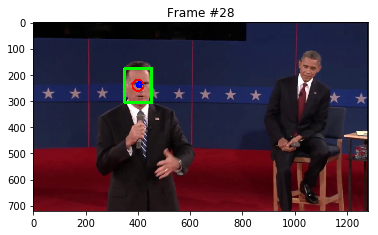

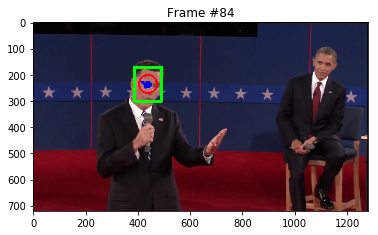

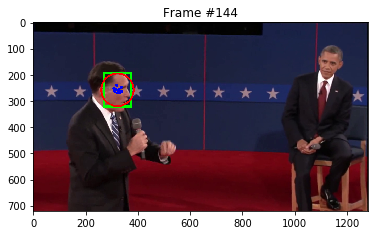

In [5]:
p = particle_cloud('pres_debate.avi', 'pres_debate.txt', 100, 20)
for i in np.arange(p.num_frames):
    p.motion()
    p.correct()
    p.resample()
    if p.current_frame in [27, 83, 143]: #0-indexing
        p.showParticles()
        plt.title('Frame #{}'.format(p.current_frame+1))
        plt.show()

### 1.2. Influence of window size

In [6]:
%%script already run, dont rerun
for w_tf in [-80, -50, -20, -10, -5, 0, 5, 10, 20, 50, 100, 150]:
    p = particle_cloud('pres_debate.avi', 'pres_debate.txt', num_particles = 100, s_dynamics = 20, s_MSE = 10, window_tf = w_tf, seed = 903424427)
    p.rollAndExportVideo("pres_debate_{}_{}_{}_{}".format(100, 20, 10, w_tf), [28, 84, 144], True)

Couldn't find program: u'already'


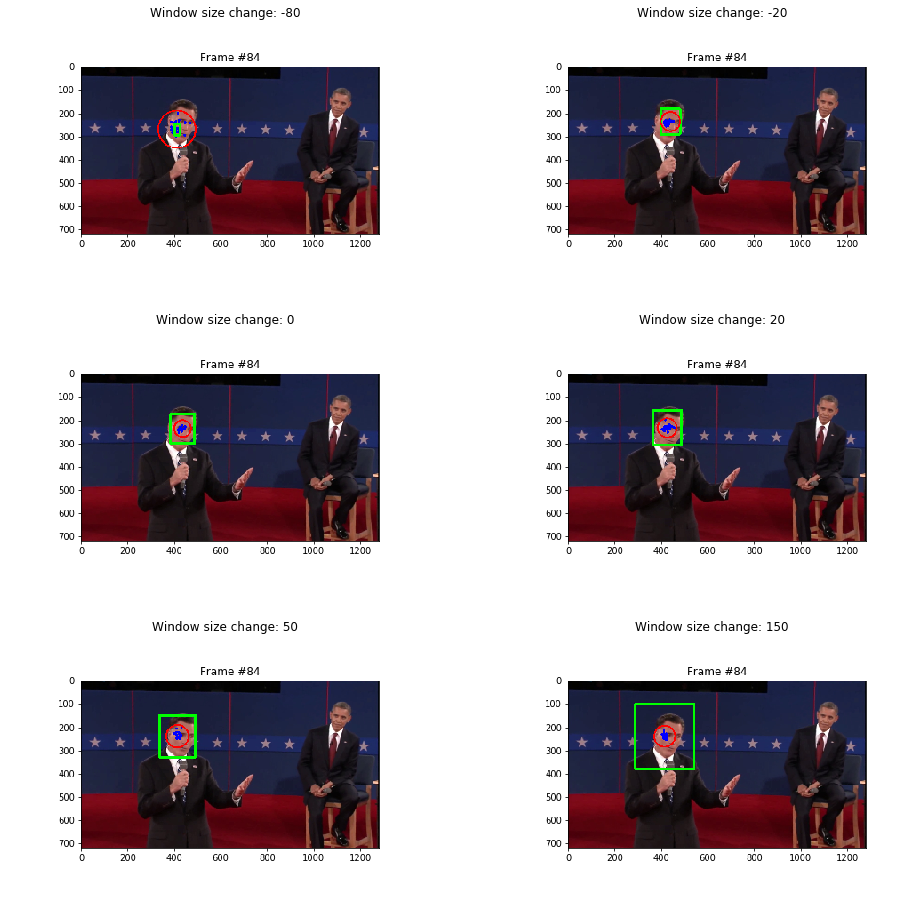

In [7]:
plt.figure(figsize=(16, 16))
for i, val in enumerate([-80, -20, 0, 20, 50, 150]):
    plt.subplot(3,2,i+1)
    plt.title('Window size change: ' + str(val))
    plt.axis('off')
    plt.imshow(cv2.cvtColor(cv2.imread('./out/pres_debate_100_20_10_{}/snapshots/marked/frame-84.png'.format(val)), cv2.COLOR_BGR2RGB))

The experiment was repeated by only changing the window size parameter. Even with a window significantly reduced in its size, the tracking gave acceptable results.  
All else being equal, here are the trade-offs of choosing the size of the window:
* A reduced window gives us better performance by containing exclusively what we want to track, without any background noise (that may change in different frames and intervenes in similarity computations) that we might observe with larger windows.  
* Too small a window can lead to a decline in performance: during the -80px experiment, the inital reference patch is mostly uniform skin. This resulted in erratic movements in the particles and rectangles, because a lot of matches can be found on the face (the similarities being very close for a lot of particles).  
* Conversely, bigger windows, especially when the background doesn't change much, can give us a more stable tracking. In particular, when Mitt Romney turned his head, it was difficult to find any match to the reference patch in smaller windows, while with bigger windows the particles were able to have a good similarity because of the familiar background, suit, etc.
* In this setting, the tracking is more stable with the particles less spread out using bigger windows because the motion is limited and the region of interest is more or less at the same area. This can become a disadvantage if this condition is not met. 

### 1.3. Influence of $\sigma_{MSE}$

In [8]:
%%script already run, dont rerun
for s_e in [1, 2, 5, 10, 20, 30]:
    p = particle_cloud('pres_debate.avi', 'pres_debate.txt', num_particles = 100, s_dynamics = 20, s_MSE = s_e, window_tf = 0, seed = 903424427)
    p.rollAndExportVideo("pres_debate_{}_{}_{}_{}".format(100, 20, s_e, 0), [28, 84, 144], True)

Couldn't find program: u'already'


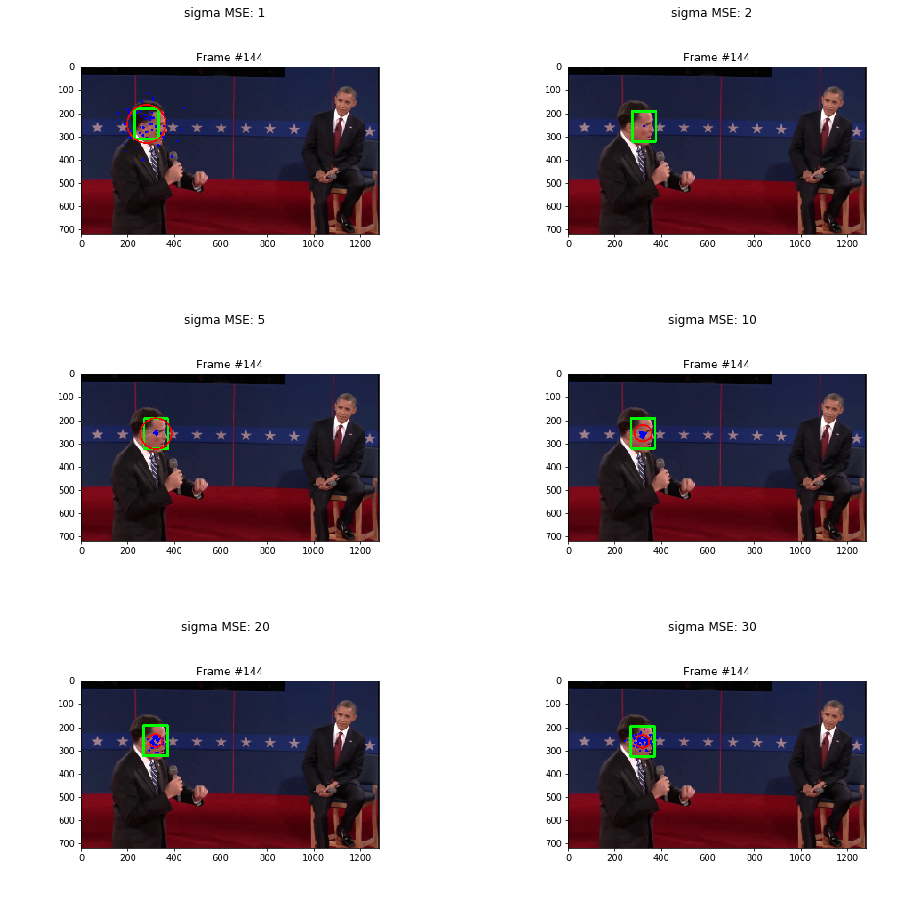

In [9]:
plt.figure(figsize=(16, 16))
for i, val in enumerate([1, 2, 5, 10, 20, 30]):
    plt.subplot(3,2,i+1)
    plt.title('sigma MSE: ' + str(val))
    plt.axis('off')
    plt.imshow(cv2.cvtColor(cv2.imread('./out/pres_debate_100_20_{}_0/snapshots/marked/frame-144.png'.format(val)), cv2.COLOR_BGR2RGB))

$\sigma_{MSE}$ intervenes in our similarity measure. It controls how lenient we should be to differences in MSEs: low values of $\sigma_{MSE}$ will give us a much higher similarity difference between two particles with different MSEs, while higher values of $\sigma_{MSE}$ would tend to give us much closer similarity scores for those same two particles.  
The consequence of this is that, when running the experiment with lower values of $\sigma_{MSE}$, and all else being equal, the particles were much less spread out, and all were concentrated on the single point that had the best similarity score. Conversely, when using higer values, our particles have more liberty to exist in the neighborhood of the best point, even if they had lower similarity scores.  
One major drawback of using very small $\sigma_{MSE}$ values is that the particle cloud is too reliant on that single, high scoring point. This gives us a poor performance (at $\sigma_{MSE} = 1$) when Mitt Romney turned his head. The single best point had a very low score and because all particles were grouped, none had a good score, which exploded the particle cloud.
The best strategy is to have a big enough value so that the algorithm can be robust against such situations, without being too big as to not have particles exploring too far and potentially scoring high with a false positive (the hands in this case).

### 1.4. Influence of the number of particles

In [10]:
%%script already run, dont rerun
for num_p in [10, 20, 50, 100, 200, 300, 500]:
    p = particle_cloud('pres_debate.avi', 'pres_debate.txt', num_particles = num_p, s_dynamics = 20, s_MSE = 10, window_tf = 0, seed = 903424427)
    p.rollAndExportVideo("pres_debate_{}_{}_{}_{}".format(num_p, 20, 10, 0), [28, 84, 144], True)

Couldn't find program: u'already'


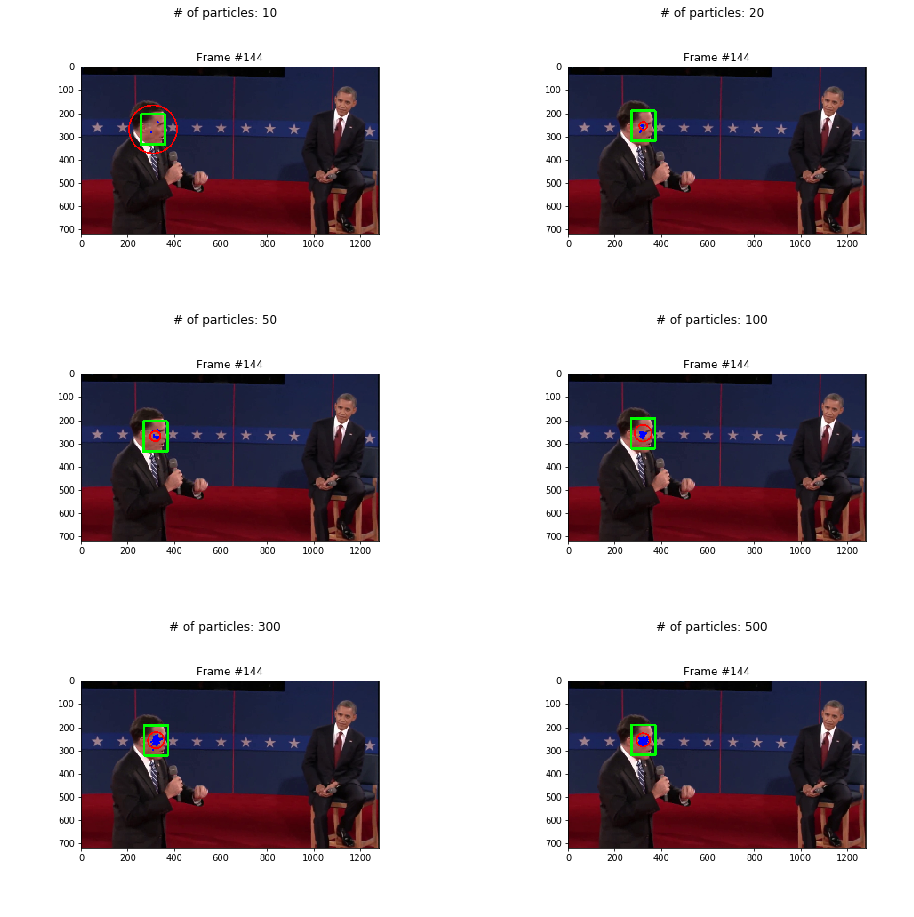

In [11]:
plt.figure(figsize=(16, 16))
for i, val in enumerate([10, 20, 50, 100, 300, 500]):
    plt.subplot(3,2,i+1)
    plt.title('# of particles: ' + str(val))
    plt.axis('off')
    plt.imshow(cv2.cvtColor(cv2.imread('./out/pres_debate_{}_20_10_0/snapshots/marked/frame-144.png'.format(val)), cv2.COLOR_BGR2RGB))

There are two main effects that can be discussed in the case of the number of particles. To some extent, they share similarities with the other parameters.
* When we are using a small number of particles, the movement of our detection box is very erratic. Because we have fewer samples to average over, the mean center of our box varies a lot from one frame to another. Using a larger number of particles, this motion is smaller.
* A higher number of particles shows some of the same results as using higer values for $\sigma_{MSE}$: because there are a lot more samples to draw, we get more values that have higher deviations from the mean when applying noise. Using large number of particles, this also results in particles that slightly more spread out. In turn, some of those particles reached Mitt Romney's hand and had a good enough similarity that the box moved there. Using very few particles, we observe the explosion of the particle cloud (and the resulting big variance circle) from the time when he turns his head.

### 1.5. Face tracking with varying noise

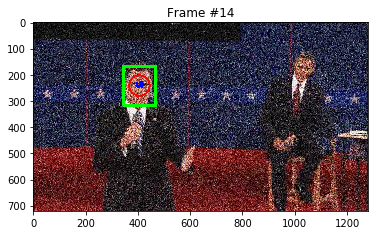

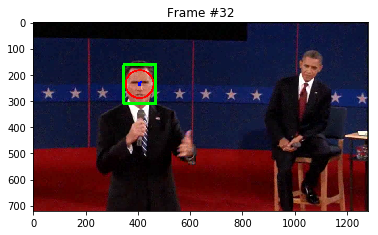

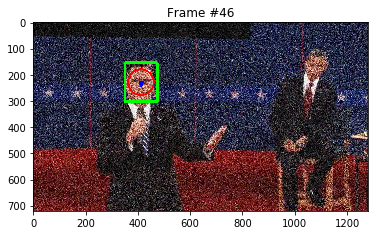

In [12]:
p = particle_cloud('noisy_debate.avi', 'noisy_debate.txt', 100, 20, window_tf = 20)
for i in np.arange(p.num_frames):
    p.motion()
    p.correct()
    p.resample()
    if p.current_frame in [13, 31, 45]: #0-indexing
        p.showParticles()
        plt.title('Frame #{}'.format(p.current_frame+1))
        plt.show()

What we observe in general is that the particles are more spread out. The circle of variance is typically larger than in the regular version of the video. The increasing and decreasing amount of noise "disturbs" the point cloud, spreading the particles and increasing the radius of the variance circle. When the noise decreases, the particles start to group back a bit, but typically less than they would with the noise-free video.

## 2. Appearance Model Update

In [13]:
class iir_particle_cloud:
    def __init__(self, seq_path, coord_path, num_particles = 20, alpha = 0.01, s_dynamics = 20, s_MSE = 10, window_tf = 0, seed = None):
        """ alpha: learning rate/trade-off between the 'best' patch and the previous template to form a new template
            s_dynamics: controls the variance when we want to draw noise for our particles 
            s_MSE: the sigma_MSE used in our similarity measure
            window_tf: the number of pixels we want to grow or shrink our base patch window (can be an a pair (row,col) or an int)"""
        
        if seed is not None: 
            np.random.seed(seed)
        
        # Frames initialization (B&W, Color)
        cap = cv2.VideoCapture(seq_path)
        self.frames = []
        self.frames_color = []
        while(cap.isOpened()):
            ret, frame = cap.read()
            if ret == False or frame is None:
                break
            self.frames.append(np.array(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), dtype = np.float))
            self.frames_color.append(np.array(frame, dtype = np.float))
        cap.release()

        # Base Patch (frame 0) + Particles, weightss initialization
        initcoord = readCoord(coord_path)
        initcoord = initcoord[[1,0,3,2]] #fix row/col
        self.template = extractPatch(self.frames[0], tupleToCenter(initcoord), initcoord[3], initcoord[2], window_tf)
        self.best = self.template
        self.particles = np.array(np.array([tupleToCenter(initcoord)] * num_particles).reshape(-1,2), dtype = np.int)
        self.weights = np.array([1./num_particles]*num_particles)
        
        # Parameters, Info about our problem
        self.num_frames = len(self.frames)
        self.current_frame = 0
        self.video_size = tuple((self.frames[0].shape[1], self.frames[0].shape[0]))
        self.sigma = s_dynamics
        self.s_MSE = s_MSE
        self.rows = self.template.shape[0]
        self.cols = self.template.shape[1]
        self.num_particles = num_particles
        self.alpha = alpha
        
    def template_update(self):
        self.template = self.alpha * self.best + (1-self.alpha) * self.template
        
    def motion(self):
        self.particles = np.array(self.particles + self.sigma * np.random.randn(self.num_particles, 2), dtype=int)
    
    def correct(self):
        similarities = np.array([similarity(self.template, extractPatch(self.frames[self.current_frame], p, self.cols, self.rows), self.s_MSE) for p in self.particles], dtype=np.float64)
        self.weights = similarities/np.sum(similarities) if np.sum(similarities) > 0 else np.array([1./self.num_particles]*self.num_particles)
        
    def resample(self, inc_frame = True):
        if inc_frame:
            self.current_frame += 1
        choice = np.random.choice(self.num_particles, self.num_particles, replace=True, p=self.weights)
        self.particles = self.particles[choice]
        self.weights = self.weights[choice]
        
        # Computing the 'best' patch as the weighted average of probable faces
        center_col = int(round(np.average(self.particles[:,1], weights=self.weights)))
        center_row = int(round(np.average(self.particles[:,0], weights=self.weights)))
        origin, opposite = centerToTuples([center_row, center_col], self.cols, self.rows, False)
        frame = self.frames[self.current_frame - 1]
        self.best = frame[origin[0]:opposite[0], origin[1]:opposite[1]]
            
    def weights_cdf(self, ticks = False):
        """ ticks: activate to see which particles have the most weight (legible when num_particles small) """
        order = self.weights.argsort()
        plt.figure()
        plt.plot(np.arange(self.num_particles), np.cumsum(self.weights[order]))
        if ticks:
            p = map(lambda x: "({}, {})".format(x[0],x[1]), self.particles[order])
            plt.xticks(order)
            plt.gcf().gca().set_xticklabels(p, rotation = 45)
            
    def showParticles(self, frame = None, particles = True, rectangle = True, circle = True):
        """ frame: debugging, plot particles on another frame
            rectangle: plot a rectangle on the tracked object, center is weighted avg of all particles 
            circle: plot the variance circle indicating spread, centered on weighted avg of all particles """
        if frame is None:
            frame = self.current_frame
        frame = np.array(self.frames_color[frame]).astype(np.uint8)
        center_col = int(round(np.average(self.particles[:,1], weights=self.weights)))
        center_row = int(round(np.average(self.particles[:,0], weights=self.weights)))
        if particles:
            for p in self.particles:
                cv2.circle(frame, tuple(p[::-1]), 5, color = (255,0,0), thickness = -1)
        if rectangle:
            origin, opposite = centerToTuples([center_row, center_col], self.cols, self.rows, True)
            cv2.rectangle(frame, origin, opposite, color = (0,255,0), thickness = 10)
        if circle:
            center = np.array([center_row, center_col])
            weighted_sum = int(round(np.dot(np.linalg.norm(self.particles - center, axis = 1), self.weights)))
            cv2.circle(frame, tuple(center[::-1]), weighted_sum, color = (0,0,255), thickness = 5)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        return frame
        
    def rollAndExportVideo(self, prefix = "video", snapshots = None, saveCDF = False):
        for directory in ['out/'+prefix, 'out/'+prefix+'/CDF', 'out/'+prefix+'/snapshots/marked', 'out/'+prefix+'/snapshots/rectangle-only']:
            if not os.path.exists(directory):
                os.makedirs(directory)

        fourcc = cv2.VideoWriter_fourcc(*'DIVX')
        out = cv2.VideoWriter('out/{}/marked.avi'.format(prefix), fourcc, 20.0, self.video_size, True)
        out_rect_only = cv2.VideoWriter('out/{}/marked-rect-only.avi'.format(prefix), fourcc, 20.0, self.video_size, True)
        
        for i in np.arange(self.num_frames - 1):
            self.template_update()
            self.motion()
            self.correct()
            if saveCDF:
                self.weights_cdf()
                plt.savefig('out/{}/CDF/frame-{}-cdf.png'.format(prefix, p.current_frame+1))
            p.resample()
            
            f = self.showParticles()
            out.write(f)
            if snapshots is not None and self.current_frame in np.array(snapshots)-1: #0-indexing
                plt.title('Frame #{}'.format(p.current_frame+1))
                plt.savefig('out/{}/snapshots/marked/frame-{}.png'.format(prefix, p.current_frame+1))
                
            f = self.showParticles(particles = False, circle = False)
            out_rect_only.write(f)
            if snapshots is not None and self.current_frame in np.array(snapshots)-1: #0-indexing
                plt.title('Frame #{}'.format(p.current_frame+1))
                plt.savefig('out/{}/snapshots/rectangle-only/frame-{}.png'.format(prefix, p.current_frame+1))
            plt.close('all') 
            
        out.release()
        out_rect_only.release()

### 2.1. Hand tracking

In [14]:
%%script already run, dont rerun
for alpha in [0.5, 0.3, 0.2]:
    for s_dyn in [5, 10, 20, 30]:
        for s_e in [5, 10, 20]:
            p = iir_particle_cloud('pres_debate.avi', 'pres_debate_hand.txt', num_particles = 200, alpha = alpha, s_dynamics = s_dyn, s_MSE = s_e, window_tf = -5, seed = 903424427)
            p.rollAndExportVideo("hand_pres_debate_{}_{}_{}".format(alpha, s_dyn, s_e), [15, 50, 140], True)

Couldn't find program: u'already'


A first coarse grid search was run to determine appropriate parameters.

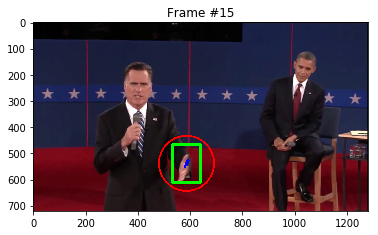

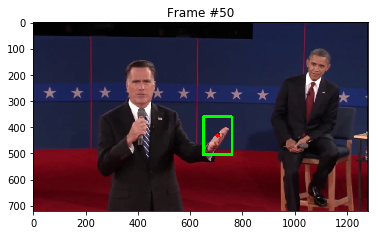

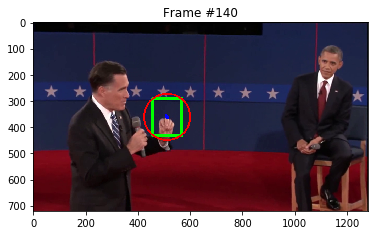

In [15]:
p = iir_particle_cloud('pres_debate.avi', 'pres_debate_hand.txt', num_particles = 200, alpha = 0.2, s_dynamics = 20, s_MSE = 5, window_tf = (-5,10), seed = 903424427)
plt.imshow(p.template, cmap='gray', vmin = 0, vmax = 255)

for i in np.arange(p.num_frames):
    p.template_update()
    p.motion()
    p.correct()
    p.resample()
    if p.current_frame in [14, 49, 139]: #0-indexing
        p.showParticles()
        plt.title('Frame #{}'.format(p.current_frame+1))
        plt.show()

### 2.2. Hand tracking with varying noise

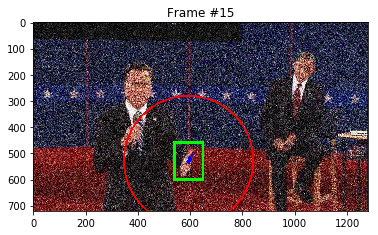

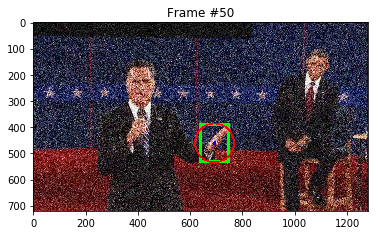

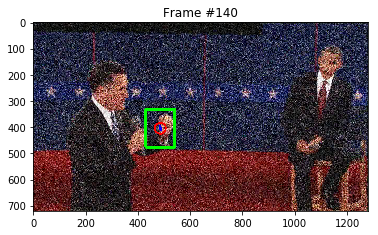

In [16]:
p = iir_particle_cloud('noisy_debate.avi', 'pres_debate_hand.txt', num_particles = 200, alpha = 0.2, s_dynamics = 20, s_MSE = 5, window_tf = (-5,10), seed = 903424427)
plt.imshow(p.template, cmap='gray', vmin = 0, vmax = 255)

for i in np.arange(p.num_frames):
    p.template_update()
    p.motion()
    p.correct()
    p.resample()
    if p.current_frame in [14, 49, 139]: #0-indexing
        p.showParticles()
        plt.title('Frame #{}'.format(p.current_frame+1))
        plt.show()

The same parameters used in the regular version worked just as well in the noisy version. The circle of variance was more often bigger than in the regular version, but there was less "lag" around frame 140 when the fist is going up and down.

## 3. Incorporating more dynamics

In [17]:
def scaler(image1, image2):
    if image1.shape[0] == 0 or image1.shape[1] == 0 or image2.shape[0] == 0 or image2.shape[1]== 0:
        return [np.zeros((2,2)), np.ones((2,2))]
    if image1.shape[0] > image2.shape[0] or image1.shape[1] > image2.shape[1]:
        image1 = cv2.resize(image1, tuple(image2.shape[::-1]), interpolation = cv2.INTER_LINEAR)
    elif image1.shape[0] < image2.shape[0] or image1.shape[1] < image2.shape[1]:
        image2 = cv2.resize(image2, tuple(image1.shape[::-1]), interpolation = cv2.INTER_LINEAR)
    return [image1, image2]

In [18]:
class flex_particle_cloud:
    def __init__(self, seq_path, coord_path, num_particles = 20, alpha = 0.01, s_dynamics = 20, s_MSE = 10, window_tf = 0, seed = None):
        """ alpha: learning rate/trade-off between the 'best' patch and the previous template to form a new template
            s_dynamics: controls the variance when we want to draw noise for our particles 
            s_MSE: the sigma_MSE used in our similarity measure
            window_tf: the number of pixels we want to grow or shrink our base patch window (can be an a pair (row,col) or an int)"""
        
        if seed is not None: 
            np.random.seed(seed)
        
        # Frames initialization (B&W, Color)
        cap = cv2.VideoCapture(seq_path)
        self.frames = []
        self.frames_color = []
        while(cap.isOpened()):
            ret, frame = cap.read()
            if ret == False or frame is None:
                break
            self.frames.append(np.array(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), dtype = np.float))
            self.frames_color.append(np.array(frame, dtype = np.float))
        cap.release()

        # Base Patch (frame 0) + Particles, weightss initialization
        initcoord = readCoord(coord_path)
        initcoord = initcoord[[1,0,3,2]] #fix row/col
        self.template = extractPatch(self.frames[0], tupleToCenter(initcoord), initcoord[3], initcoord[2], window_tf)
        self.best = self.template
        self.particles = np.array(np.array([np.concatenate((tupleToCenter(initcoord), [self.template.shape[0], self.template.shape[1]*1./self.template.shape[0]]))] * num_particles).reshape(-1,4), dtype = np.float)
        self.weights = np.random.random((num_particles))
        
        # Flag for when our particles give us a small similarity with the template
        self.freeze_learning = False
        
        # Parameters, Info about our problem
        self.num_frames = len(self.frames)
        self.current_frame = 0
        self.video_size = tuple((self.frames[0].shape[1], self.frames[0].shape[0]))
        self.sigma = s_dynamics
        self.s_MSE = s_MSE
        self.num_particles = num_particles        
        self.alpha = alpha
        
    def template_update(self):
        if self.alpha == 0 or self.freeze_learning:
            return
        [b, t] = scaler(self.best, self.template)
        if b.shape[0] == 2 and b.shape[1] == 2: #degenerate case
            return
        self.template = self.alpha * b + (1-self.alpha) * t
        
    def motion(self):
        noise = np.matmul(np.random.randn(self.num_particles, 4), self.sigma * np.diag([1,1,4,0.001]))
        self.particles = np.array(self.particles + noise, dtype=np.float)
        # Fix for negative scales and aspect ratio
        self.particles[self.particles[:,3] < 0] = np.mean(self.particles[:,3])
        self.particles[self.particles[:,2] < 0] = 20
    
    def correct(self):
        similarities = np.array([similarity(scaler(self.template, extractPatch(self.frames[self.current_frame], p[0:2].astype(int), int(round(p[2]*p[3])), int(round(p[2])))), None, self.s_MSE) for p in self.particles], dtype=np.float64)
        # Raise flag to stop learning from patches that won't be significant
        self.freeze_learning = (np.sum(similarities) < 1e-10 or similarities.max()/similarities.min() < 10)
        if not self.freeze_learning:
            self.weights = similarities/np.sum(similarities) if np.sum(similarities) > 0 else np.array([1./self.num_particles]*self.num_particles)

    def resample(self, inc_frame = True):
        if inc_frame:
            self.current_frame += 1
        if not self.freeze_learning:
            choice = np.random.choice(self.num_particles, self.num_particles, replace=True, p=self.weights)
            self.particles = self.particles[choice]
            self.weights = self.weights[choice]

            # Computing the 'best' patch as the weighted average of probable faces
            center_col = int(round(np.average(self.particles[:,1], weights=self.weights)))
            center_row = int(round(np.average(self.particles[:,0], weights=self.weights)))
            mean_scale = np.average(self.particles[:,2], weights=self.weights)
            mean_ar = np.average(self.particles[:,3], weights=self.weights)
            rows = int(round(mean_scale))
            cols = int(round(mean_scale * mean_ar))
            origin, opposite = centerToTuples([center_row, center_col], cols, rows, False)
            frame = self.frames[self.current_frame - 1]
            self.best = frame[origin[0]:opposite[0], origin[1]:opposite[1]]
            
    def weights_cdf(self, ticks = False):
        """ ticks: activate to see which particles have the most weight (legible when num_particles small) """
        order = self.weights.argsort()
        plt.figure()
        plt.plot(np.arange(self.num_particles), np.cumsum(self.weights[order]))
        if ticks:
            p = map(lambda x: "({}, {})".format(x[0],x[1]), self.particles[order])
            plt.xticks(order)
            plt.gcf().gca().set_xticklabels(p, rotation = 45)
            
    def showParticles(self, frame = None, particles = True, rectangle = True, circle = True):
        """ frame: debugging, plot particles on another frame
            rectangle: plot a rectangle on the tracked object, center is weighted avg of all particles 
            circle: plot the variance circle indicating spread, centered on weighted avg of all particles """
        if frame is None:
            frame = self.current_frame
        frame = np.array(self.frames_color[frame]).astype(np.uint8)
        center_col = int(round(np.average(self.particles[:,1], weights=self.weights)))
        center_row = int(round(np.average(self.particles[:,0], weights=self.weights)))
        mean_scale = np.average(self.particles[:,2], weights=self.weights)
        mean_ar = np.average(self.particles[:,3], weights=self.weights)
        rows = int(round(mean_scale))
        cols = int(round(mean_scale * mean_ar))

        if particles:
            for p in self.particles[:,0:2]:
                cv2.circle(frame, tuple(p[::-1].astype(int)), 2, color = (255,0,0), thickness = -1)
        if rectangle:
            origin, opposite = centerToTuples([center_row, center_col], cols, rows, True)
            cv2.rectangle(frame, origin, opposite, color = (0,255,0), thickness = 2)
        if circle:
            center = np.array([center_row, center_col])
            weighted_sum = int(round(np.dot(np.linalg.norm(self.particles[:,0:2] - center, axis = 1), self.weights)))
            cv2.circle(frame, tuple(center[::-1].astype(int)), weighted_sum, color = (0,0,255), thickness = 2)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        return frame
        
    def rollAndExportVideo(self, prefix = "video", snapshots = None, saveCDF = False):
        for directory in ['out/'+prefix, 'out/'+prefix+'/CDF', 'out/'+prefix+'/snapshots/marked', 'out/'+prefix+'/snapshots/rectangle-only']:
            if not os.path.exists(directory):
                os.makedirs(directory)

        fourcc = cv2.VideoWriter_fourcc(*'DIVX')
        out = cv2.VideoWriter('out/{}/marked.avi'.format(prefix), fourcc, 20.0, self.video_size, True)
        out_rect_only = cv2.VideoWriter('out/{}/marked-rect-only.avi'.format(prefix), fourcc, 20.0, self.video_size, True)
        
        for i in np.arange(self.num_frames - 1):
            self.template_update()
            self.motion()
            self.correct()
            if saveCDF:
                self.weights_cdf()
                plt.savefig('out/{}/CDF/frame-{}-cdf.png'.format(prefix, p.current_frame+1))
            p.resample()
            
            f = self.showParticles()
            out.write(f)
            if snapshots is not None and self.current_frame in np.array(snapshots)-1: #0-indexing
                plt.title('Frame #{}'.format(p.current_frame+1))
                plt.savefig('out/{}/snapshots/marked/frame-{}.png'.format(prefix, p.current_frame+1))
                
            f = self.showParticles(particles = False, circle = False)
            out_rect_only.write(f)
            if snapshots is not None and self.current_frame in np.array(snapshots)-1: #0-indexing
                plt.title('Frame #{}'.format(p.current_frame+1))
                plt.savefig('out/{}/snapshots/rectangle-only/frame-{}.png'.format(prefix, p.current_frame+1))
            plt.close('all')    
            
        out.release()
        out_rect_only.release()

### 3.1. Crossing pedestrian tracking

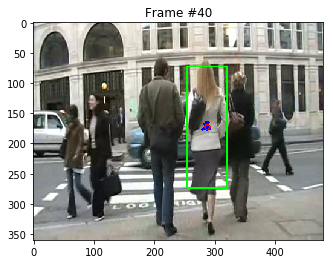

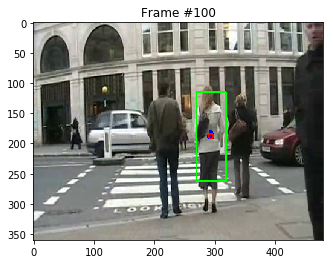

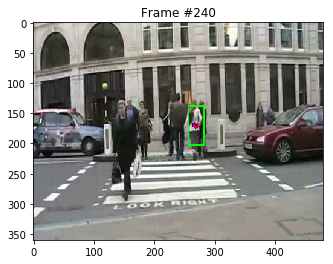

In [19]:
p = flex_particle_cloud('pedestrians.avi', 'pedestrians.txt', num_particles = 40, alpha = 0.03, s_dynamics = 2, s_MSE = 20, window_tf = 0, seed = 903424427)
plt.imshow(p.template, cmap='gray', vmin = 0, vmax = 255)

for i in np.arange(p.num_frames):
    p.template_update()
    p.motion()
    p.correct()
    p.resample()
    if p.current_frame in [39, 99, 239]: #0-indexing
        p.showParticles()
        plt.title('Frame #{}'.format(p.current_frame+1))
        plt.show()

### 3.2. Influence of the number of particles

In [20]:
%%script already run, dont rerun
for num_p in [10, 20, 40, 80, 100, 200, 400, 1000]:
    p = flex_particle_cloud('pedestrians.avi', 'pedestrians.txt', num_particles = num_p, alpha = 0.03, s_dynamics = 2, s_MSE = 20, seed = 903424427)
    p.rollAndExportVideo("pedestrians_{}".format(num_p), [40, 100, 240], True)

Couldn't find program: u'already'


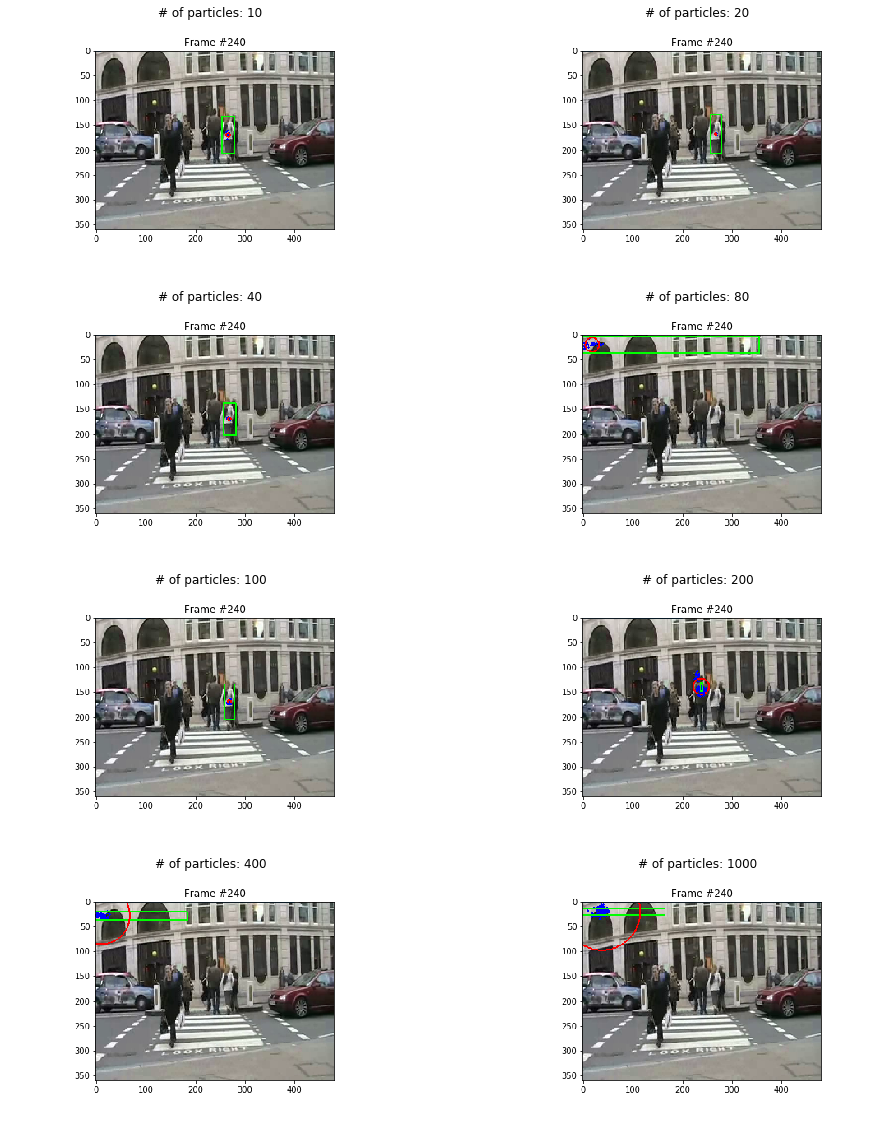

In [21]:
plt.figure(figsize=(16, 20))
for i, val in enumerate([10, 20, 40, 80, 100, 200, 400, 1000]):
    plt.subplot(4,2,i+1)
    plt.title('# of particles: ' + str(val))
    plt.axis('off')
    plt.imshow(cv2.cvtColor(cv2.imread('./out/pedestrians_{}/snapshots/marked/frame-240.png'.format(val)), cv2.COLOR_BGR2RGB))

All else being equal, the optimal number of particles for this video seems to be aroud 20-40. Lower values (like 10) suffer from the same problem as before, which is stability: not only does the rectangle move a lot beween frames, but its shape also changes drastically (because scale and aspect ratio are a part of the state). So, we would typically want to pick a higher number of particles.  
While for this precise frame, using 100 particles gave us good results, the particle cloud took a long time to recover from the first occlusion, and the detection box was attached to the person on the left before going back to the woman in white.
Other higher values (> 40) are typically suffering a lot from the occlusion part, with no recovery.
  
The value for this experiment is different from the debate video due to the occlusion. The position of the woman during that time remains about the same and we freeze the template learning and resampling during the time we suspect an occlusion (low similarities) in the algorithm. However, by using a higher number of particles, we get the same effect as discussed earlier: because there are more of them, it is more probable that one of them will encounter an area that looks similar enough to stick there. Likewise the freeze part of the algorithm is not an exact science (we don't have the timeframes of the occlusion), so it is probable that there was resampling at that point. Combining these two factors give us the results we can observe here when using too many particles.